# 資料預處理

In [1]:
# import
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math
from tensorflow.keras.callbacks import EarlyStopping
tf.compat.v1.enable_eager_execution()
tf.compat.v1.executing_eagerly()
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# 載入資料集
df = pd.read_csv('Traffic2017_new.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
# 找到 2024/1/1 00:00 作為起始點
start_index = df[df['datetime'] == '2017-01-08 00:00'].index[0]
df = df.loc[start_index:].reset_index(drop=True)
# 移動特徵向前一筆
lags = ['totalVolume_lag_1', 'totalVolume_lag_2', 'totalVolume_lag_3', 
    'totalVolume_lag_4', 'totalVolume_lag_5', 'totalVolume_lag_6', 'totalVolume_lag_7']
df[lags] = df[lags].shift(-1)
df = df.iloc[:-1].reset_index(drop=True)


# 分割訓練與測試集
train_df = df[(df['datetime'] >= '2017-01-08 00:00') & (df['datetime'] <= '2017-09-30 23:00')].reset_index(drop=True)
test_df = df[df['datetime'] >= '2017-10-01 00:00'].reset_index(drop=True)


# 定義兩組特徵及目標欄位
input1_features = ['time', 'day', 'weekend_holiday', 'totalVolume']
input2_features = ['totalVolume_lag_1', 'totalVolume_lag_2', 'totalVolume_lag_3', 
                   'totalVolume_lag_4', 'totalVolume_lag_5', 'totalVolume_lag_6', 'totalVolume_lag_7']
target = 'totalVolume'

# MinMaxScaler 標準化
scaler_X1 = MinMaxScaler()
scaler_X2 = MinMaxScaler()
scaler_y = MinMaxScaler()
X1_train_scaled = scaler_X1.fit_transform(train_df[input1_features])
X2_train_scaled = scaler_X2.fit_transform(train_df[input2_features])
y_train_scaled = scaler_y.fit_transform(train_df[[target]])
X1_test_scaled = scaler_X1.transform(test_df[input1_features])
X2_test_scaled = scaler_X2.transform(test_df[input2_features])
y_test_scaled = scaler_y.transform(test_df[[target]])

# 建立序列資料 (以時間步長 24 製作滑動窗口)
time_steps = 24
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
X1_train_seq, y_train_seq = create_sequences(X1_train_scaled, y_train_scaled, time_steps)
X2_train_seq = np.array([X2_train_scaled[i + time_steps - 1] for i in range(len(X2_train_scaled) - time_steps)])
X2_train_seq = X2_train_seq.reshape(-1, 1, len(input2_features))
X1_test_concat = np.concatenate((X1_train_scaled[-time_steps:], X1_test_scaled), axis=0)
X2_test_concat = np.concatenate((X2_train_scaled[-time_steps:], X2_test_scaled), axis=0)
y_test_concat  = np.concatenate((y_train_scaled[-time_steps:], y_test_scaled), axis=0)
X1_test_seq, y_test_seq = create_sequences(X1_test_concat, y_test_concat, time_steps)
X2_test_seq = np.array([X2_test_concat[i + time_steps - 1] for i in range(len(X2_test_concat) - time_steps)])
X2_test_seq = X2_test_seq.reshape(-1, 1, len(input2_features))

# 設置 EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 雙分支 BiLSTM 模型
input1 = Input(shape=(X1_train_seq.shape[1], X1_train_seq.shape[2]))
input2 = Input(shape=(X2_train_seq.shape[1], X2_train_seq.shape[2]))
lstm1 = Bidirectional(LSTM(units=128, activation='tanh'))(input1)
lstm2 = Bidirectional(LSTM(units=128, activation='tanh'))(input2)
concat = Concatenate()([lstm1, lstm2])
ff = Dense(units=256, activation='relu')(concat)
ff = Dense(units=128, activation='relu')(ff)
output = Dense(units=1, activation='linear')(ff)
# 建立及編譯模型
model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer='adam', loss='mae')

# 訓練模型
history = model.fit(
    [X1_train_seq, X2_train_seq], y_train_seq,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0
)
# 預測與還原
test_loss = model.evaluate([X1_test_seq, X2_test_seq], y_test_seq, verbose=0)

y_pred_scaled = model.predict([X1_test_seq, X2_test_seq], batch_size=128)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# 評估模型表現
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred))
mape = mean_absolute_percentage_error(y_test_actual, y_pred)

print(f'Test MAE for iteration : {mae}')
print(f'Test RMSE for iteration: {rmse}')
print(f'Test MAPE for iteration: {mape}')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\xdgml\anaconda3\envs\tensorflo\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\xdgml\anaconda3\envs\tensorflo\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Test MAE for iteration : 189.33236797351776
Test RMSE for iteration: 319.9799125359269
Test MAPE for iteration: 0.07273828661503359


# SHAP可解釋

In [12]:
import shap
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough 
# 計算shap值
explainer = shap.DeepExplainer(model, [X1_train_seq[:100],X2_train_seq[:100]])
shap_values = explainer.shap_values([X1_test_seq[50:51],X2_test_seq[50:51]], check_additivity=False)

C:\Users\xdgml\anaconda3\envs\tensorflo\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [13]:
# 合併兩個 SHAP 分支結果
cyclical_value = shap_values[1].reshape(1, 7, 1)
shap_values_test = shap_values[0].reshape(1, 96, 1)
concat_values = np.concatenate((shap_values_test, cyclical_value), axis=1)

##  每一個時間步(24) × 每個特徵(4) + 每個週期性特徵(7)(共103個)

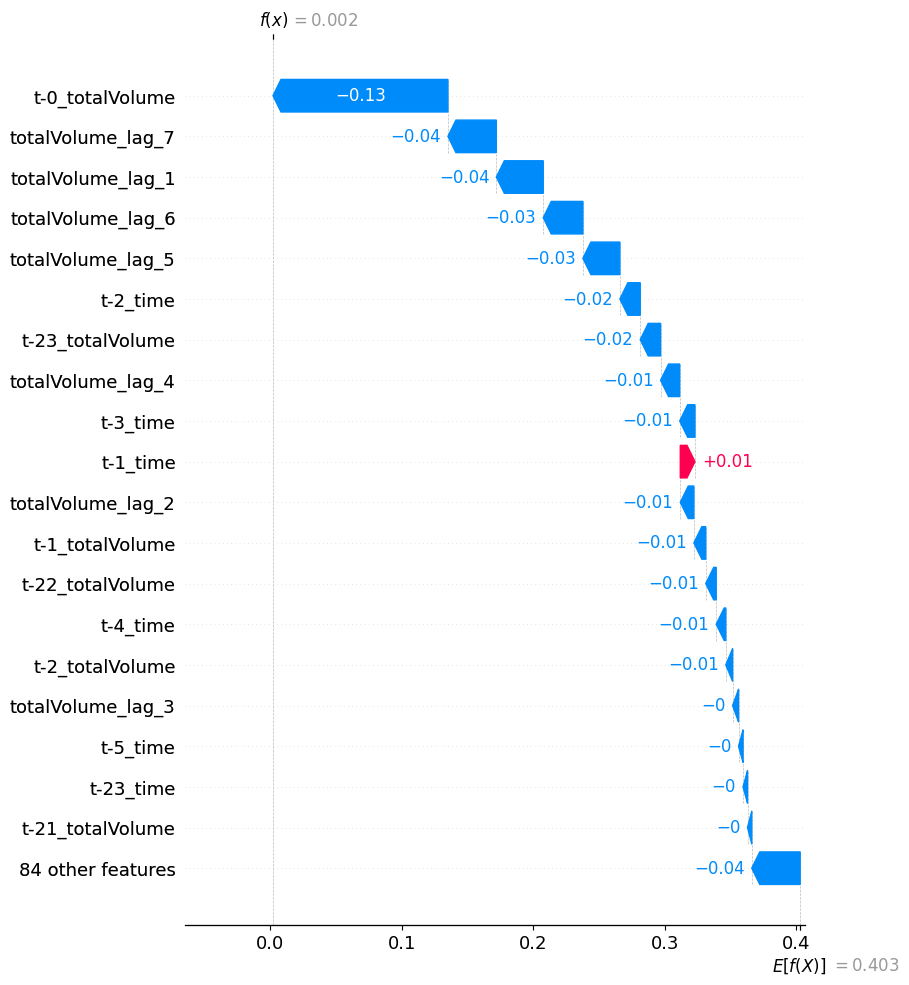

In [14]:
# 定義feature name
feature_names = [f't-{time_steps-1-i}_{input1_features[j]}' for i in range(time_steps) for j in range(len(input1_features))] + input2_features

# 畫出SHAP圖
shap.waterfall_plot(shap.Explanation(values=concat_values[0, :, 0],
                                     base_values=explainer.expected_value[0],
                                     feature_names=feature_names), max_display=20)

## 各時間步與週期性特徵(24+7個)

🔹 每個時間步 + lag 特徵的 SHAP 總貢獻


t-23                -0.019627
t-22                -0.012112
t-21                -0.006601
t-20                -0.003161
t-19                -0.002522
t-18                -0.002676
t-17                -0.002202
t-16                -0.001374
t-15                -0.000801
t-14                -0.000555
t-13                -0.000456
t-12                -0.000406
t-11                -0.000465
t-10                -0.000693
t-9                 -0.000910
t-8                 -0.000961
t-7                 -0.001154
t-6                 -0.001639
t-5                 -0.004332
t-4                 -0.009861
t-3                 -0.016091
t-2                 -0.022444
t-1                  0.001127
t-0                 -0.130794
totalVolume_lag_1   -0.035675
totalVolume_lag_2   -0.010324
totalVolume_lag_3   -0.004511
totalVolume_lag_4   -0.014531
totalVolume_lag_5   -0.028106
totalVolume_lag_6   -0.030139
totalVolume_lag_7   -0.036809
dtype: float64

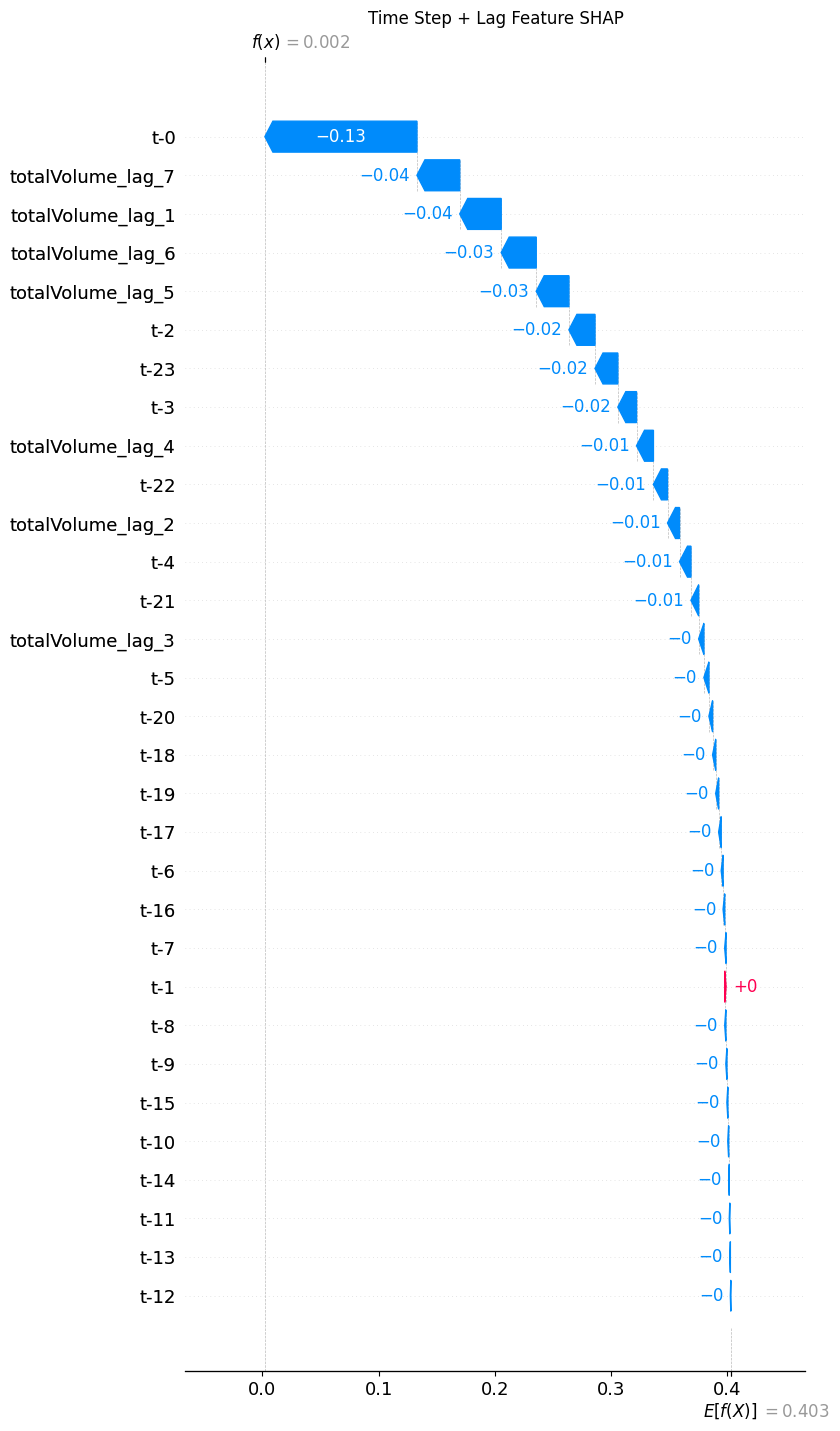

In [18]:
import matplotlib.pyplot as plt
# 取出 SHAP 向量
shap_vector = concat_values[0, :, 0]  # shape: (103,)
# 將前96個轉成 (24, 4)
shap_seq = shap_vector[:96].reshape(24, 4)
# 每個時間步的 SHAP 值總和
shap_by_timestep = shap_seq.sum(axis=1)  # shape: (24,)
# 後7 個是週期性特徵（input2）
shap_lag = shap_vector[96:]  # shape: (7,1)
# 組合所有 SHAP 貢獻為一個 pandas Series
step_labels = [f"t-{23 - i}" for i in range(24)]
lag_labels = input2_features
shap_contrib_1 = pd.Series(np.concatenate([shap_by_timestep, shap_lag]), index=step_labels + lag_labels)

# 顯示
print("🔹 每個時間步 + lag 特徵的 SHAP 總貢獻")
display(shap_contrib_1)
explanation_1 = shap.Explanation(
    values=shap_contrib_1.values,
    base_values=explainer.expected_value[0],
    feature_names=shap_contrib_1.index.tolist()
)
shap.waterfall_plot(explanation_1, max_display=31, show=False)
plt.title("Time Step + Lag Feature SHAP")
plt.show()

## 每個特徵在 24 步內總和 + 週期性特徵：共 4 + 7 維

🔹 每個特徵跨 24 步 + lag 特徵的 SHAP 總貢獻


time                -0.041318
day                 -0.016538
weekend_holiday     -0.001564
totalVolume         -0.181289
totalVolume_lag_1   -0.035675
totalVolume_lag_2   -0.010324
totalVolume_lag_3   -0.004511
totalVolume_lag_4   -0.014531
totalVolume_lag_5   -0.028106
totalVolume_lag_6   -0.030139
totalVolume_lag_7   -0.036809
dtype: float64

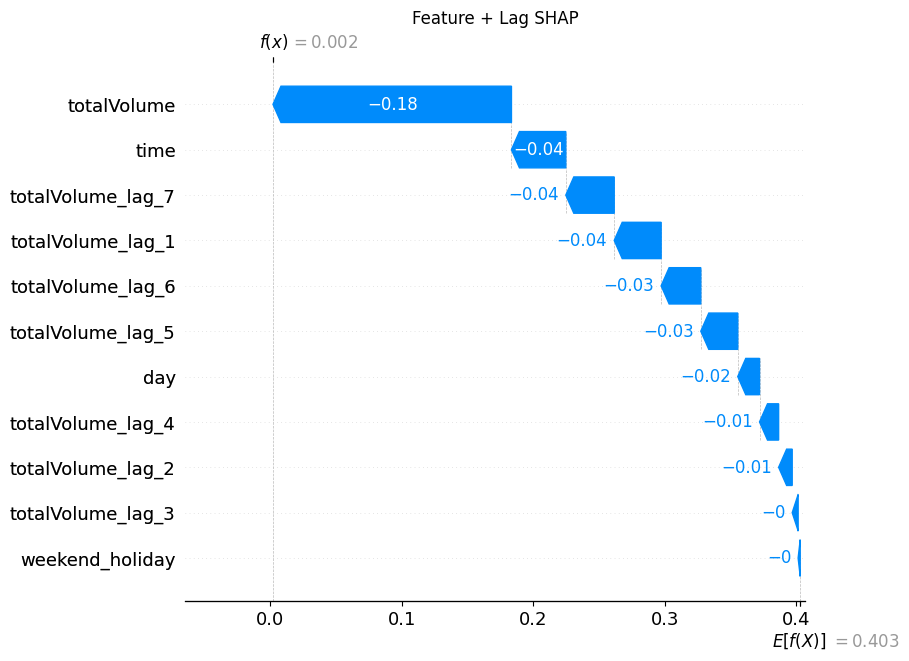

In [16]:
# input1 的 SHAP 矩陣仍然是 (24, 4)
shap_seq = shap_vector[:96].reshape(24, 4)
# 對 4 個 input1 特徵進行總和（跨所有時間步）
shap_by_feature = shap_seq.sum(axis=0)  # shape: (4,)
# lag 特徵
shap_lag = shap_vector[96:]
# 合併
shap_contrib_2 = pd.Series(np.concatenate([shap_by_feature, shap_lag]), index=input1_features + input2_features)

# 顯示
print("🔹 每個特徵跨 24 步 + lag 特徵的 SHAP 總貢獻")
display(shap_contrib_2)
explanation_2 = shap.Explanation(
    values=shap_contrib_2.values,
    base_values=explainer.expected_value[0],
    feature_names=shap_contrib_2.index.tolist()
)
shap.waterfall_plot(explanation_2, max_display=11, show=False)
plt.title("Feature + Lag SHAP")
plt.show()